In [1]:
import torch
import torchmetrics
from torch import nn
import torch.nn.functional as F
import numpy as np
from pathlib import Path

In [2]:
torch.cuda.is_available(), torch.__version__

(True, '2.0.0+cu117')

In [3]:
wd = Path("../data")

In [6]:
for sample in (wd/"cubesxy"/"train").glob("*.npz"):
    data = np.load(sample)
    X = data["X"]
    y = data["y"]
    klass, freq = np.unique(y, return_counts=True)
    print(sorted(list(zip(klass, freq)), key=lambda x: x[1], reverse=True))
    break

[(1, 23359), (4, 21171), (9, 4350), (0, 848)]


In [7]:
data["X"].shape

(222, 224, 13, 10)

In [8]:
data["y"].shape

(222, 224)

In [10]:
y = data["y"].reshape(-1)

In [11]:
y.shape

(49728,)

In [5]:
from torch.utils.data import Dataset, DataLoader

class S2ACube(Dataset):
    def __init__(self, cubes_dir):
        self.cubes = list(cubes_dir.glob("*.npz"))
        
    def __len__(self): 
        return len(self.cubes)

    def __getitem__(self, idx):
        data = np.load(self.cubes[idx])
        return data["X"],data["y"]

In [6]:
ds = S2ACube(cubes_dir=Path("../data/cubes/train"))

In [9]:
def timeseries_collate(data):    
    Xs, ys = zip(*data)
    X = np.vstack(Xs)
    y = np.hstack(ys)
    # handle nan's
    X = torch.from_numpy(X.astype(np.float32)).transpose(1,2)
    X = torch.nan_to_num(X, nan=0.0)
    return {"X": X, "y": torch.from_numpy(y)}

dl = DataLoader(ds, batch_size=1, shuffle=True, collate_fn=timeseries_collate)

In [10]:
batch = next(iter(dl))

In [11]:
batch["X"].dtype, batch["y"].dtype

(torch.float32, torch.uint8)

In [12]:
list(zip(*torch.unique(batch["y"], return_counts=True, sorted=True)))

[(tensor(8, dtype=torch.uint8), tensor(50676))]

In [13]:
batch["X"].shape, batch["y"].shape

(torch.Size([50676, 10, 13]), torch.Size([50676]))

In [14]:
def _conv(ni, nf, ks):
    return nn.Conv1d(ni, nf, kernel_size=ks, stride=1, padding=ks//2)
    
def _conv_layer(ni, nf, ks, drop=0.0):
    return nn.Sequential(_conv(ni, nf, ks), nn.BatchNorm1d(nf), nn.ReLU(), nn.Dropout(p=drop))

def stacked_conv(ni, nf, ks, drop):
    return nn.Sequential(
        _conv_layer(ni, nf, ks, drop=drop),
        nn.MaxPool1d(kernel_size=2, stride=2),
        _conv_layer(nf, nf, ks, drop=0.0),
        # nn.AdaptiveAvgPool1d(output_size=1),
        nn.Flatten()
    )

class Pixel(nn.Module):
    def __init__(self, num_bands, num_classes, timeperiod=13, hidden_dims=32, drop=0.25):
        super().__init__()
        self.bn = nn.BatchNorm1d(num_features=num_bands)
        self.conv1 = stacked_conv(ni=num_bands, nf=hidden_dims, ks=3, drop=drop)
        self.conv2 = stacked_conv(ni=num_bands, nf=hidden_dims, ks=5, drop=drop)
        self.head = nn.Sequential(
            nn.Linear(in_features=2 * (hidden_dims * (timeperiod // 2)), out_features=4 * hidden_dims),
            nn.BatchNorm1d(4 * hidden_dims),
            nn.ReLU(),
            nn.Linear(in_features=4 * hidden_dims, out_features=num_classes)
        )
        self.drop = drop
    
    def forward(self, x):
        # normalize the input
        x = self.bn(x)
        print(x.shape)
        
        x1 = self.conv1(x)
        x2 = self.conv2(x)
        print(x1.shape, x2.shape)
        
        # bs x (2 * nf)
        x3 = torch.cat([x1, x2], dim=1)
        x3 = F.dropout(x3, p=self.drop)
        print(x3.shape)
        
        x3 =  self.head(x3)
        
        return x3

In [15]:
model = Pixel(num_bands=10, num_classes=10, hidden_dims=32)

In [16]:
model.head

Sequential(
  (0): Linear(in_features=384, out_features=128, bias=True)
  (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=10, bias=True)
)

In [17]:
out = model(batch["X"])
out.shape

torch.Size([50676, 10, 13])
torch.Size([50676, 192]) torch.Size([50676, 192])
torch.Size([50676, 384])


torch.Size([50676, 10])

In [18]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

In [19]:
out.shape, batch["y"].shape

(torch.Size([50676, 10]), torch.Size([50676]))

In [20]:
loss = criterion(out, batch["y"])

In [21]:
from torchmetrics.classification import MulticlassAccuracy, F1Score, ConfusionMatrix

In [22]:
accuracy = MulticlassAccuracy(num_classes=10, average="none")
f1 = F1Score(task="multiclass", num_classes=10, average="none")
score = accuracy(out, batch["y"])
f1_score = f1(out, batch["y"])

In [23]:
score

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3398,
        0.0000])

In [24]:
f1_score

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5072,
        0.0000])

In [25]:
loss

tensor(2.0091, grad_fn=<AddBackward0>)

In [26]:
from torchview import draw_graph
from torchinfo import summary
import graphviz
graphviz.set_jupyter_format('png')

'svg'

In [27]:
summary(model, input_size=(2, 10, 12))

torch.Size([2, 10, 12])
torch.Size([2, 192]) torch.Size([2, 192])
torch.Size([2, 384])


/home/mjonir/mambaforge/envs/time-series-for-lulc/lib/python3.11/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/home/mjonir/mambaforge/envs/time-series-for-lulc/lib/python3.11/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
Pixel                                    [2, 10]                   --
├─BatchNorm1d: 1-1                       [2, 10, 12]               20
├─Sequential: 1-2                        [2, 192]                  --
│    └─Sequential: 2-1                   [2, 32, 12]               --
│    │    └─Conv1d: 3-1                  [2, 32, 12]               992
│    │    └─BatchNorm1d: 3-2             [2, 32, 12]               64
│    │    └─ReLU: 3-3                    [2, 32, 12]               --
│    │    └─Dropout: 3-4                 [2, 32, 12]               --
│    └─MaxPool1d: 2-2                    [2, 32, 6]                --
│    └─Sequential: 2-3                   [2, 32, 6]                --
│    │    └─Conv1d: 3-5                  [2, 32, 6]                3,104
│    │    └─BatchNorm1d: 3-6             [2, 32, 6]                64
│    │    └─ReLU: 3-7                    [2, 32, 6]                --
│    │    └

In [28]:
model = Pixel(num_bands=10, num_classes=10, hidden_dims=64)

torch.Size([2, 10, 12])
torch.Size([2, 384]) torch.Size([2, 384])
torch.Size([2, 768])


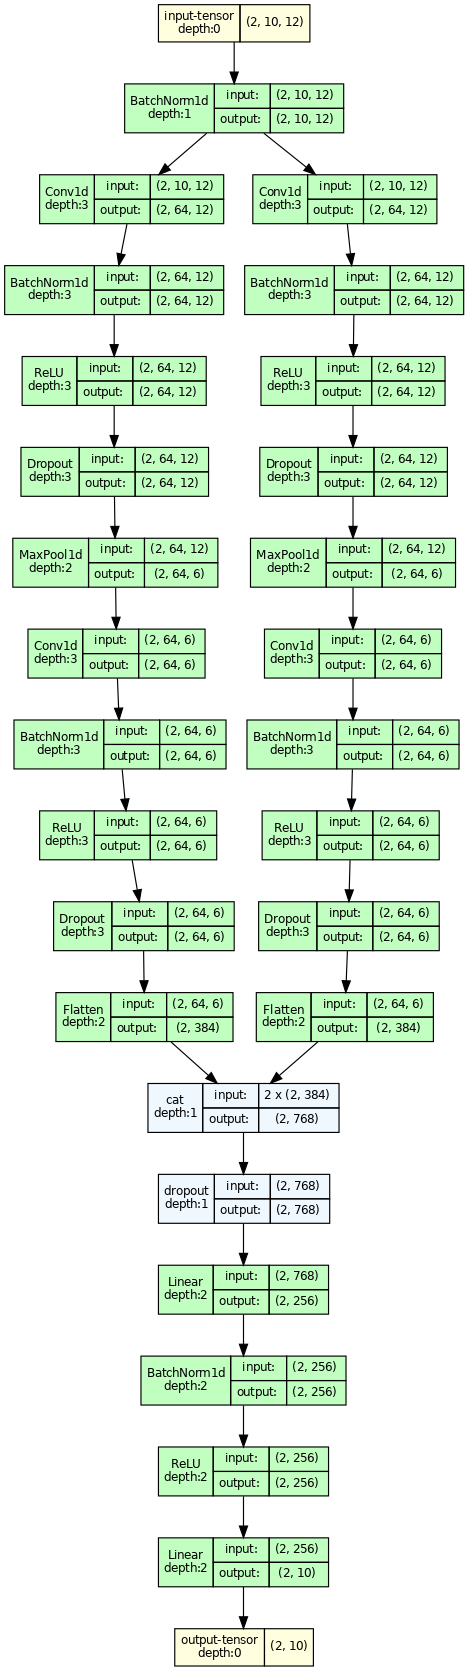

In [29]:
model_graph = draw_graph(model, input_size=(2, 10, 12), device='meta')
model_graph.visual_graph